<a href="https://colab.research.google.com/github/manuvillalba-uclm/Natural_Lenguaje_Processing-ELM/blob/main/Machine_Learning_NLP_Vectorization_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# dataframes library
!pip install pyspellchecker 
!pip install contractions
!pip install nltk --upgrade
!pip install emoji
import nltk
nltk.download("popular")
nltk.download('vader_lexicon') #sentiment analysis
nltk.download('twython') #twitter not necessary

Requirement already up-to-date: nltk in /usr/local/lib/python3.6/dist-packages (3.5)


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

False

In [2]:
import pandas as pd
import re


from nltk.tokenize.casual import TweetTokenizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

#Correcciones y emoji
import emoji
from textblob import TextBlob
from spellchecker import SpellChecker
import contractions
from multiprocessing import Pool

#Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

#Feature selection 
from sklearn.feature_selection import SelectKBest, chi2

#Classification
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB

#Visualization and results
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from tabulate import tabulate

In [3]:
raw_dataset_tweets = pd.read_csv('https://raw.githubusercontent.com/manuvillalba-uclm/Natural_Lenguaje_Processing-ELM/main/labeled_data.csv?token=AGI3DY5JJD5B6YDVPN6RALS73X4VW', index_col=[0])
ds_alt_twitter = pd.read_csv('https://raw.githubusercontent.com/manuvillalba-uclm/Natural_Lenguaje_Processing-ELM/main/preprocesado_hard.csv?token=AGI3DY4ZE7B2GTK3AS3OVJC73X4GE', index_col=[0])
ds_alt_twitter = ds_alt_twitter.iloc[:,0]
ds_alt_twitter


0        ['trash', 'man', 'take', 'clean', 'hous', 'alw...
1        ['boy', 'dat', 'bad', 'place', 'coffin', 'hoe'...
2        ['dawg', 'confus', 'bitch', 'fuck', 'ever', 'c...
3                               ['tranni', 'like', 'look']
4        ['bitch', 'true', 'hear', 'told', 'faker', 'sh...
                               ...                        
24778    ['scriptur', 'trash', 'tl', 'right', 'lie', 'b...
24779    ['gone', 'redneck', 'babi', 'crazi', 'wrong', ...
24780    ['want', 'di', 'like', 'fuck', 'young', 'dat',...
24781              ['lie', 'bitch', 'tell', 'got', 'wild']
24782    ['coll', 'ruffl', 'tac', 'pink', 'yellow', 'or...
Name: tweet, Length: 24783, dtype: object

# Vectorization


In [4]:
def identity_tokenizer(text):
    return text

In [5]:
%%time
# TF-IDF
vectorizer = TfidfVectorizer(lowercase=False, max_features=8000, ngram_range=(1,4))    
vectors = vectorizer.fit_transform(ds_alt_twitter)

feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
tweets_vectorization = pd.DataFrame(denselist, columns=feature_names)


CPU times: user 1min 47s, sys: 6.78 s, total: 1min 54s
Wall time: 1min 54s


In [6]:
tweets_vectorization

,a1,a3,ab,abil,abl,abo,absolut,abu,abus,accent,accept,accid,accident,accord,account,accur,acknowledg,across,act,act hate,act nigga,actin,action,activ,actor,actual,actual trash,ad,adam,add,addict,address,admit,adopt,ador,adult,advanc,advic,advis,ae,...,yep,yer,yesterday,yet,yet like,yet trash,yo,yo as,yo back,yo bird,yo choos,yo da,yo good,yo like,yo main,yo momma,yo new,yo nigga,yo real,yo see,yo trna,yoga,yokel,york,you,young,young porn,younger,youtub,yr,yu,yuan,yuh,yung,yup,zebra,zero,zimmerman,zone,zoo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24780,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.308487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24781,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Feature Selection

In [7]:
class_label = raw_dataset_tweets.copy()
class_label = class_label['class']


In [8]:
%%time

n_tweets = tweets_vectorization.shape[0]
n_features = tweets_vectorization.shape[1]
n_features = int(n_features*0.3)

class_label = class_label.iloc[0:n_tweets]
class_label.reset_index(inplace = True, drop = True)
#quitamos el 70% de las features, se supone que en función del target class_label
tweets_vectorization_selected = SelectKBest(chi2, k=n_features).fit_transform(tweets_vectorization,class_label)
tweets_vectorization_selected

df_tweets_vectorization_selected = pd.DataFrame(data=tweets_vectorization_selected)
df_tweets_vectorization_selected['target']= class_label

CPU times: user 1.57 s, sys: 311 ms, total: 1.88 s
Wall time: 1.41 s


# Classification

In [9]:
tweets_classification = df_tweets_vectorization_selected.copy()

In [39]:
model = BernoulliNB()

In [40]:
train, test = train_test_split(tweets_classification, test_size=0.30)
train.reset_index(inplace = True)
test.reset_index(inplace = True)
print(train.shape)
print(test.shape)

(17348, 2402)
(7435, 2402)


In [41]:
model.fit(train.loc[:, train.columns != 'target'], train['target'])
labels = model.predict(test.loc[:, test.columns != 'target'])

# Evaluation

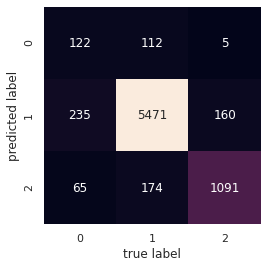

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
mat = confusion_matrix(test['target'], labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [43]:

precision, recall, fscore, support = score(test['target'], labels)
print(tabulate({'Name': ['hate speech', 'offensive lenguage', 'neither'], 'Class': [0,1,2],'Precision':precision, 'Recall': recall, 'F-Score': fscore, 'Support': support} , headers=['Name','Class','Precision', 'Recall','F-Score','Support'], tablefmt='orgtbl'))

| Name               |   Class |   Precision |   Recall |   F-Score |   Support |
|--------------------+---------+-------------+----------+-----------+-----------|
| hate speech        |       0 |    0.51046  | 0.2891   |  0.369138 |       422 |
| offensive lenguage |       1 |    0.932663 | 0.950321 |  0.941409 |      5757 |
| neither            |       2 |    0.820301 | 0.868631 |  0.843774 |      1256 |


We know that accuracy is not a correct metric to evaluate these types of problems, but we are just curious

In [44]:
acc = accuracy_score(test['target'], labels)
print ('Acc', acc)

Acc 0.8989912575655683
